# Import some packages

You should load packages you may need in this project first

In [1]:
import skimage.io
import skimage.color
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
import random

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


# Load character data from the dataset subfolder


In [2]:
# provide your code here
DATASET_DIR = './dataset/'
classes = os.listdir(DATASET_DIR)
data = []
for cls in classes:
    files = os.listdir(DATASET_DIR +cls)
    for f in files:
        img = skimage.io.imread(DATASET_DIR +cls+"/"+f)
        try:
            img = skimage.color.rgb2gray(img)
        except:
            pass
        data.append({
            'x': img,
            'y': cls
        })
        
random.shuffle(data) 

E:\anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  # Remove the CWD from sys.path while we load stuff.


# create train data set and test data set 
Using 80/20 rule, 80 precent for trainning, and 20 percent for testing.

In [3]:
X = [d['x'] for d in data]
y = [d['y'] for d in data]

ys = list(np.unique(y))
y = [ys.index(v) for v in y]

x_train = X[:int(.8 * len(y))]
y_train = y[:int(.8 * len(y))]

x_test  = X[int(.8 * len(y)):]
y_test  = y[int(.8 * len(y)):]

# Examming and Understand data set for trainning


In [4]:
# you may print out some infomation about train data set 
print(x_train[0])
print(y_train)
print(len(y_train))

[[  0   0   2   1   0 145 255 255 254 255 255  81   2   0   0   1   0   0
    0   0]
 [  0   4   0   0   2 151 252 253 255 250 255 254 217   5   0   0   0   0
    0   0]
 [  0   0   0   2   0 146 255 117   0   4  77 255 255  52   0   0   0   0
    0   0]
 [  0   1   0   0   3 143 255  32   3   0   1 121 255 255   4   0   0   0
    0   0]
 [  1   0   4   0   0 151 254  33   1   0   0  10 255 252   0   0   0   0
    0   0]
 [  1   0   0   2   1 143 255  29   0   5   0   0 255 255   1   0   0   0
    0   0]
 [  0   0   0   1   0 150 255  32   0   2   0 150 253  56   0   0   0   0
    0   0]
 [  0   1   0   0   1 147 253 228   4 219 224 255 253  59   0   1   0   0
    0   0]
 [  0   1   0   0   0 148 255 255 255 255 254 255 221   2   0   0   0   0
    0   0]
 [  2   0   2   2   1 145 253 254 230 222 254 255 228   5   3   1   0   0
    0   0]
 [  0   0   0   0   0 149 255  72  23   6  45 255 254  61   0   0   0   0
    0   0]
 [  0   2   0   0   3 144 252  31   0   0   0 122 255 254   0   0

# Decide a few parameters for trainning

such as batch size, epochs, image size in rows and colomns, etc.

In [5]:
# you decide those parameters below
batch_size = 256
num_classes = 65
epochs = 73

# input image dimensions
img_rows, img_cols = 20, 20

In [6]:
#Extend the data chennels to 4 dimemsions
def extend_channel(data):
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        
    return data

x_train = extend_channel(np.array(x_train))
x_test = extend_channel(np.array(x_test))

input_shape = x_train.shape[1:]

# Data normalization

In [7]:
x_train  = x_train.astype('float32')
x_test   = x_test.astype('float32')
x_train /= 255
x_test  /= 255

#TODO
y_train  = keras.utils.np_utils.to_categorical(y_train)
y_test   = keras.utils.np_utils.to_categorical(y_test)

# Create a CNN model for character recognition

This is an important part of this project. You have to create a cnn model using tensorflow and keras to train the data.


In [9]:
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


class Res1:
    """ Returns Shape: (4*c, w//s, w//s) """
    
    def __init__(self, a, b, kernel=3):
        self.a      = a
        self.b      = b
        self.kernel = kernel
    
    def __call__(self, X):
        shortcut   = X
        X           = Conv2D(self.a, 1, self.b)(X)
        X           = BatchNormalization()(X)
        X           = ReLU()(X)
        X           = Conv2D(self.a, self.kernel, 1)(X)
        X           = BatchNormalization()(X)
        X           = ReLU()(X)
        X           = Conv2D(self.a * 4, 1, 1)(X)
        X           = BatchNormalization()(X)
        shortcut   = Conv2D(self.a * 4, self.kernel, self.b)(shortcut)
        shortcut   = BatchNormalization()(shortcut)
        X           = Add()([shortcut, X])
        X           = ReLU()(X)
        return X
    

class Res2:
    """
        Returns Shape: (a, w, w)
    """
    def __init__(self, a):
        self.a  = a
    
    def __call__(self, X):
        shortcut = X
        X         = Conv2D(self.a // 4, 1, 1)(X)
        X         = BatchNormalization()(X)
        X         = ReLU()(X)
        X         = Conv2D(self.a // 4, 1, 1)(X)
        X         = BatchNormalization()(X)
        X         = ReLU()(X)
        X         = Conv2D(self.a, 1, 1)(X)
        X         = BatchNormalization()(X)
        X         = Add()([shortcut, X])
        X         = ReLU()(X)
        return X
        

def resNet(input_shape=(20, 20, 1)):
    
    X_input = Input(input_shape)
    
    X       = Conv2D(filters = 64, kernel_size = 3, strides = 2)(X_input)    # (9, 9, 64)
    X       = BatchNormalization()(X)
    X       = ReLU()(X)
    X       = MaxPool2D(pool_size = 3, strides = 2)(X)                       # (4, 4, 64)
    
    X       = Res1(64, 1)(X)                                            # (2, 2, 256)
    X       = Res2(256)(X)                                              # (2, 2, 256)
    X       = Res2(256)(X)                                              # (2, 2, 256)
    
    X       = Res1(128, 1, 1)(X)                                        # (2, 2, 512)
    X       = Res2(512)(X)                                              # (2, 2, 512)
    X       = Res2(512)(X)                                              # (2, 2, 512)
    X       = Res2(512)(X)                                              # (2, 2, 512)
    X       = Res2(512)(X)                                              # (2, 2, 512)
    X       = Res2(512)(X)                                              # (2, 2, 512)
    
    X       = AveragePooling2D(2)(X)
    
    X       = Flatten()(X)
    X       = Dense(65, activation="softmax")(X)
    
    model   = Model(inputs = X_input, outputs = X)
    return model

model = resNet((img_rows, img_cols, 1))

# Compile the model

In [10]:
model.compile(optimizer = tf.keras.optimizers.Adam(.001), loss="categorical_crossentropy", metrics=["categorical_crossentropy", "acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 20, 20, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 9, 9, 64)     640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 9, 9, 64)     256         conv2d_5[0][0]                   
__________________________________________________________________________________________________
re_lu_3 (ReLU)                  (None, 9, 9, 64)     0           batch_normalization_4[0][0]      
______________________________________________________________________________________________

# Train your model


In [11]:
history  = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_test, y_test))

# finetuning
model.compile(optimizer = tf.keras.optimizers.Adam(.0005), loss="categorical_crossentropy", metrics=["categorical_crossentropy", "acc"])
history1 = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_test, y_test))

Train on 12920 samples, validate on 3231 samples
Epoch 1/73
12920/12920 [==============================] - 16s 1ms/sample - loss: 1.5231 - categorical_crossentropy: 1.5231 - acc: 0.6738 - val_loss: 4.4534 - val_categorical_crossentropy: 4.4534 - val_acc: 0.0430
Epoch 2/73
12920/12920 [==============================] - 12s 891us/sample - loss: 0.3279 - categorical_crossentropy: 0.3279 - acc: 0.9132 - val_loss: 5.0796 - val_categorical_crossentropy: 5.0796 - val_acc: 0.0430
Epoch 3/73
12920/12920 [==============================] - 13s 990us/sample - loss: 0.1626 - categorical_crossentropy: 0.1626 - acc: 0.9594 - val_loss: 5.6438 - val_categorical_crossentropy: 5.6438 - val_acc: 0.0173
Epoch 4/73
12920/12920 [==============================] - 13s 987us/sample - loss: 0.0902 - categorical_crossentropy: 0.0902 - acc: 0.9791 - val_loss: 6.3270 - val_categorical_crossentropy: 6.3270 - val_acc: 0.0226
Epoch 5/73
12920/12920 [==============================] - 13s 994us/sample - loss: 0.0819 - c

12920/12920 [==============================] - 16s 1ms/sample - loss: 0.0358 - categorical_crossentropy: 0.0358 - acc: 0.9906 - val_loss: 0.1679 - val_categorical_crossentropy: 0.1679 - val_acc: 0.9641
Epoch 40/73
12920/12920 [==============================] - 16s 1ms/sample - loss: 0.0298 - categorical_crossentropy: 0.0298 - acc: 0.9926 - val_loss: 0.1483 - val_categorical_crossentropy: 0.1483 - val_acc: 0.9660
Epoch 41/73
12920/12920 [==============================] - 17s 1ms/sample - loss: 0.0231 - categorical_crossentropy: 0.0231 - acc: 0.9937 - val_loss: 0.1199 - val_categorical_crossentropy: 0.1199 - val_acc: 0.9715
Epoch 42/73
12920/12920 [==============================] - 15s 1ms/sample - loss: 0.0216 - categorical_crossentropy: 0.0216 - acc: 0.9942 - val_loss: 0.1084 - val_categorical_crossentropy: 0.1084 - val_acc: 0.9752
Epoch 43/73
12920/12920 [==============================] - 15s 1ms/sample - loss: 0.0192 - categorical_crossentropy: 0.0192 - acc: 0.9941 - val_loss: 0.1121

12920/12920 [==============================] - 15s 1ms/sample - loss: 0.0223 - categorical_crossentropy: 0.0223 - acc: 0.9933 - val_loss: 0.1452 - val_categorical_crossentropy: 0.1452 - val_acc: 0.9697
Epoch 5/73
12920/12920 [==============================] - 14s 1ms/sample - loss: 0.0203 - categorical_crossentropy: 0.0203 - acc: 0.9938 - val_loss: 0.1673 - val_categorical_crossentropy: 0.1673 - val_acc: 0.9622
Epoch 6/73
12920/12920 [==============================] - 16s 1ms/sample - loss: 0.0195 - categorical_crossentropy: 0.0195 - acc: 0.9943 - val_loss: 0.1428 - val_categorical_crossentropy: 0.1428 - val_acc: 0.9703
Epoch 7/73
12920/12920 [==============================] - 15s 1ms/sample - loss: 0.0194 - categorical_crossentropy: 0.0194 - acc: 0.9942 - val_loss: 0.1284 - val_categorical_crossentropy: 0.1284 - val_acc: 0.9734
Epoch 8/73
12920/12920 [==============================] - 15s 1ms/sample - loss: 0.0226 - categorical_crossentropy: 0.0226 - acc: 0.9931 - val_loss: 0.2244 - v

12920/12920 [==============================] - 15s 1ms/sample - loss: 0.0169 - categorical_crossentropy: 0.0169 - acc: 0.9947 - val_loss: 0.0974 - val_categorical_crossentropy: 0.0974 - val_acc: 0.9799
Epoch 43/73
12920/12920 [==============================] - 15s 1ms/sample - loss: 0.0169 - categorical_crossentropy: 0.0169 - acc: 0.9944 - val_loss: 0.0959 - val_categorical_crossentropy: 0.0959 - val_acc: 0.9808
Epoch 44/73
12920/12920 [==============================] - 15s 1ms/sample - loss: 0.0171 - categorical_crossentropy: 0.0171 - acc: 0.9948 - val_loss: 0.1005 - val_categorical_crossentropy: 0.1005 - val_acc: 0.9793
Epoch 45/73
12920/12920 [==============================] - 15s 1ms/sample - loss: 0.0172 - categorical_crossentropy: 0.0172 - acc: 0.9948 - val_loss: 0.1004 - val_categorical_crossentropy: 0.1004 - val_acc: 0.9796
Epoch 46/73
12920/12920 [==============================] - 15s 1ms/sample - loss: 0.0169 - categorical_crossentropy: 0.0169 - acc: 0.9948 - val_loss: 0.0993

# Visualize training results

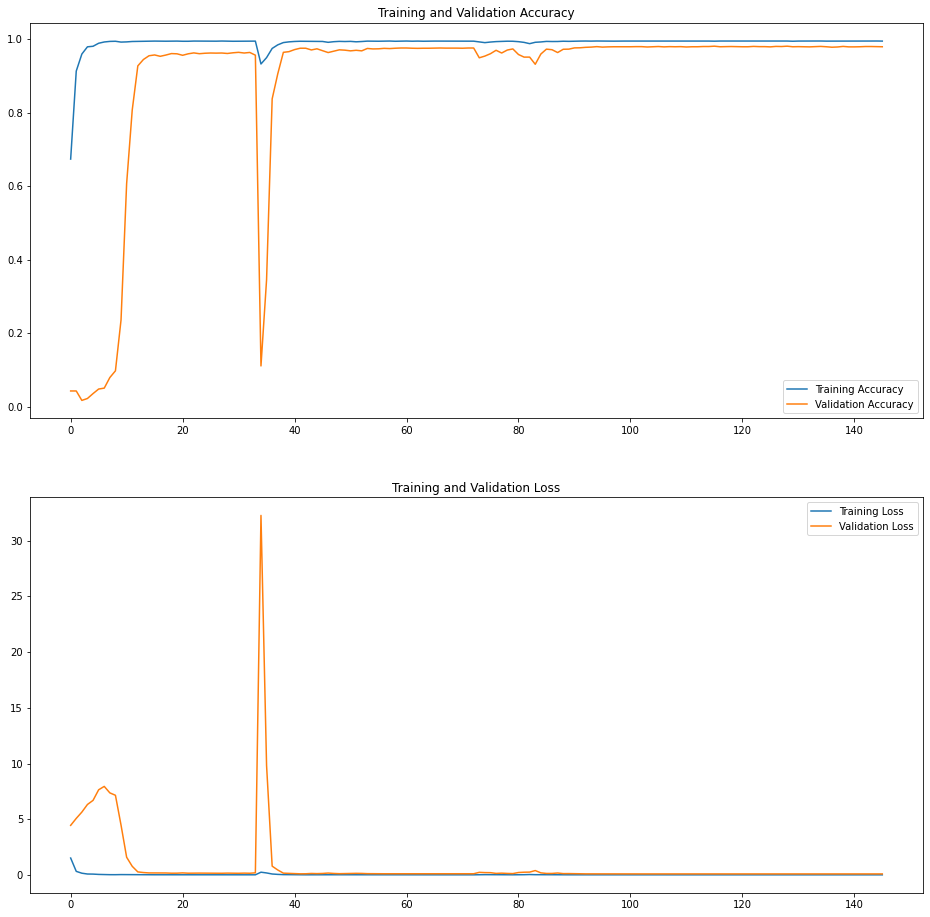

In [12]:
loss          = history.history["loss"] + history1.history["loss"]
val_loss      = history.history["val_loss"] + history1.history["val_loss"]
acc           = history.history["acc"] + history1.history["acc"]
val_acc       = history.history["val_acc"] + history1.history["val_acc"]
epochs_range  = np.arange(epochs * 2)

plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Evaluation 

Evaluate your model with test dataset.

make sure your model accuracy should be more than 99 percent. Otherwise, you have to go back to fine tune your model with whatever methods you have learned to improve its accuracy. You have to handle over-fitting or under-fitting problem you may encounter.

In [13]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[-1])

3231/3231 [==============================] - 1s 365us/sample - loss: 0.0980 - categorical_crossentropy: 0.0980 - acc: 0.9793
Test loss: 0.09798876614003177
Test accuracy: 0.97926337


# Save your model weights

You should save your model for car plate recognition purpose later.


In [14]:
# when you finish training, you should save your model in a file
# for carplate_recognition.ipynb
# since it will use this model to recognize car plates 
model.save_weights('resNet.h5')